/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



    NaiveBayes
              precision    recall  f1-score   support

        Fake       0.94      0.95      0.95      4739
        Real       0.95      0.93      0.94      4241

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



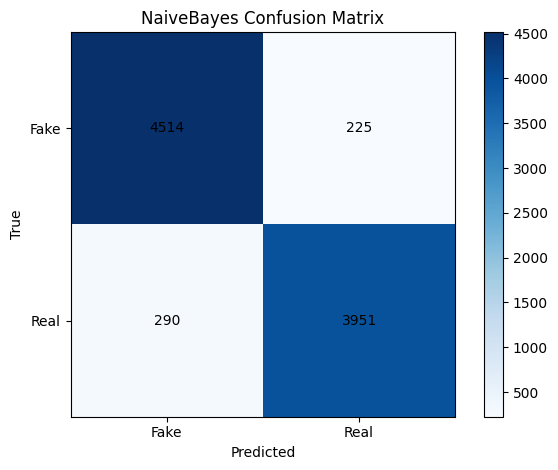

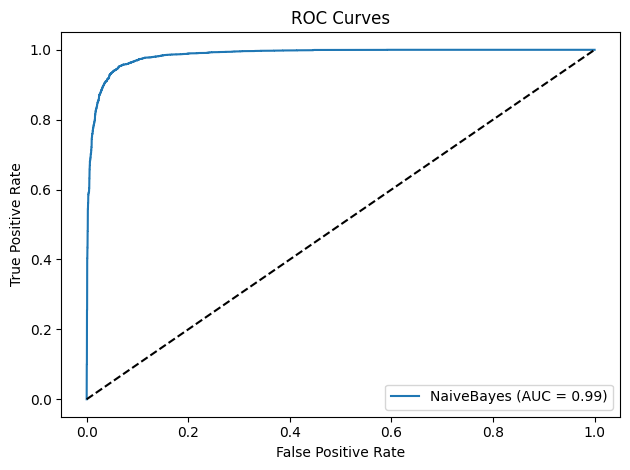

No repeated-character tokens found.


In [5]:
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_curve, auc, classification_report)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Data Loading
# Accepts separate files for fake and real news in the same folder
def load_data(fake_path='Fake.csv', true_path='True.csv'):
    df_fake = pd.read_csv(fake_path)
    df_true = pd.read_csv(true_path)
    df_fake['label'] = 0
    df_true['label'] = 1
    # Combine title + text
    df_fake.dropna(inplace=True)
    df_true.dropna(inplace=True)
    df_fake['text_full'] = df_fake['title'] + ' ' + df_fake['text']
    df_true['text_full'] = df_true['title'] + ' ' + df_true['text']
    df = pd.concat([df_fake, df_true], ignore_index=True).sample(frac=1, random_state=123)
    texts = df['text_full'].astype(str).tolist()
    labels = df['label'].tolist()
    return texts, labels

#Custom Tokenizer + Lemmatization Pipeline
class CustomTokenizer:
    def __init__(self):
        #contains common contractions
        self.contraction_map = {
            r"\bcan't\b": 'cannot', r"\bI'm\b": 'I am', r"\bwon't\b": 'will not',
            r"\bn't\b": ' not', r"\b've\b": ' have', r"\b're\b": ' are'
        }
        self.repeat_regex = re.compile(r"(\w)\1{2,}") #matches for more than 2 word repeats

    #matches for more than 2 word repeats
    def normalize_repeats(self, word):
        match = self.repeat_regex.search(word)
        char = match.group(1)
        count = len(match.group(0))
        return f"{char} <REPEAT:{count - 1}>"

    def tokenize(self, text):
        #lowering normalises the text
        text = text.lower()
        for pat, repl in self.contraction_map.items():
            text = re.sub(pat, repl, text)
        raw_tokens = re.findall(r"\w+|<REPEAT:\d+>", text)
        tokens = [self.normalize_repeats(tok) if self.repeat_regex.search(tok) else tok
                  for tok in raw_tokens]
        tagged = pos_tag(tokens)
        lemmas = [simple_lemmatize(tok, pos) for tok, pos in tagged]
        return lemmas

# simple search to tag token as a verb, adj, adv, or noun
def pos_tag(tokens):
    tags = []
    for tok in tokens:
        if re.search(r'ing$|ed$|ize$|ify$', tok): tags.append('VERB')
        elif re.search(r'ous$|ful$|able$|ive$|less$|al$', tok): tags.append('ADJ')
        elif re.search(r'ly$', tok): tags.append('ADV')
        else: tags.append('NOUN')
    return list(zip(tokens, tags))

#Simple Lemmatizer/Stemming
def simple_lemmatize(token, pos):
    if pos == 'VERB':
        if token.endswith('ing'): return token[:-3] or token
        if token.endswith('ed'):  return token[:-2] or token
    if pos == 'NOUN' and token.endswith('s'):
        return token[:-1]
    return token

#Feature extraction
def build_features(corpus, method='tfidf'):
    if method == 'bow':
        vec = CountVectorizer(tokenizer=CustomTokenizer().tokenize)
    else:
        vec = TfidfVectorizer(tokenizer=CustomTokenizer().tokenize)
    X = vec.fit_transform(corpus)
    return X, vec

#Evaluation & Visualization Helpers
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=['Fake','Real'])
    cm = confusion_matrix(y_test, y_pred)
    return report, cm

def plot_confusion(cm, title='Confusion Matrix'):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ['Fake', 'Real'])
    plt.yticks(ticks, ['Fake', 'Real'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center')
    plt.tight_layout()
    plt.show()


def plot_roc(models, X_test, y_test):
    plt.figure()
    for name, model in models.items():
        if hasattr(model, 'predict_proba'):
            probs = model.predict_proba(X_test)[:,1]
        else:
            probs = model.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_repeat_distribution(corpus):
    counts = []
    for text in corpus:
        counts.extend([int(m.group(1)) for m in re.finditer(r'<REPEAT:(\d+)>', text)])
    if not counts:
        print("No repeated-character tokens found.")
        return
    plt.figure()
    plt.hist(counts, bins=range(1, max(counts)+2))
    plt.xlabel('Repeat Count')
    plt.ylabel('Frequency')
    plt.title('Distribution of <REPEAT:n> Tokens')
    plt.tight_layout()
    plt.show()

# 7. Main Pipeline
if __name__ == '__main__':
    texts, labels = load_data()

    X_tfidf, _ = build_features(texts, method='tfidf')
    X_bow, _ = build_features(texts, method='bow')

    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, labels, test_size=0.2, random_state=123)

    models = {
        'NaiveBayes': MultinomialNB().fit(X_train, y_train),
        #'MLP':        MLPClassifier(hidden_layer_sizes=(100,), max_iter=300).fit(X_train, y_train)
    }

    # Evaluate & plot
    for name, model in models.items():
        report, cm = evaluate_model(model, X_test, y_test)
        print(f"\n    {name}\n{report}")
        plot_confusion(cm, title=f"{name} Confusion Matrix")

    plot_roc(models, X_test, y_test)
    plot_repeat_distribution(texts)
    plt.show()
